Con questo notebook alleniamo il primo segmenter, quello che utilizzerà le immagini "flair" del dataset.

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt


SEED = 1234
tf.random.set_seed(SEED)

cwd = os.getcwd() #get current working directory
physical_devices = tf.config.list_physical_devices('GPU') 
#physical_devices = tf.config.list_physical_devices('CPU') 



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# RUNNING


Se abbiamo eseguito correttamente il notebook Tesi-04-dispatch, dovremmo avere la cartella Extracted/Flair con al suo interno le immagini, convertite in 3 canali, della vista "flair" del dataset BraTS (slice).

Per prima cosa, proviamo a usare il segmenter pre-trainato direttamente su queste immagini


In [ ]:
%cd /content/drive/My Drive/Segmenter/segmenter
!pip install .
!pip install --ignore-installed PyYAML 

In [ ]:
#!python -m segm.inference --model-path "/content/drive/My Drive/Models/Pre-trained/PASCAL - Seg-L-Mask16/checkpoint.pth" -i "/content/drive/My Drive/Immagine" -o segmaps/
!python -m segm.inference --model-path "~/Google\ Drive/Il mio Drive//Models/Pre-trained/PASCAL - Seg-L-Mask16/checkpoint.pth" -i "/content/drive/My Drive/Immagine" -o segmaps/

libc++abi: terminating with uncaught exception of type std::length_error: vector


Il risultato è abbastanza un disastro: 

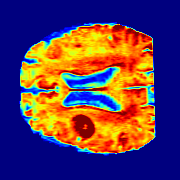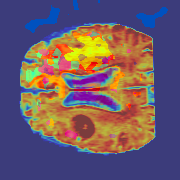

I possibili problemi sono


* Troppe classi? Ce ne sono 60...
  * potrei provare a modificare il numero di classi...
    * problema: quante classi ha il nostro dataset???
* Non c'è un minimo di fine tuning!
  * problema: come si fa il training?? 



Una possibile soluzione a questo problema potrebbe essere di utilizzare una versione del segmenter che abbia il numero di classi uguale a quelle del nostro dataset.

Problema: andrebbe TRAINATO DA ZERO!

Proviamoci.

Per prima cosa, dobbiamo cercare di capire quante classi ha il nostro dataset. Per fare ciò, prendiamo tutte le immagini e calcoliamone i valori distinti

In [ ]:
dataset_name = os.path.join('/content/drive/My Drive/Unzipped/', "brats2019_slice_training_tfrecords/brats2019_slice_training.tfrecords")
raw_dataset = tf.data.TFRecordDataset(dataset_name)
import numpy as np

count = 0


image_list = []

for raw_record in raw_dataset:
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    parsed = tf.train.Example.FromString(raw_record.numpy())
    feature = parsed.features.feature

    raw_img_seg = feature['seg'].bytes_list.value[0]
    img_seg = tf.image.decode_png(raw_img_seg)

    image_list.append(img_seg)

tensor = np.uint8(image_list)
print(tensor.shape)
print((np.unique(tensor)))

Lo stesso controllo va però fatto sulle immagini prodotte dal precedente botebook, il dispatch, che crea le annotazioni! Questo perchè vogliamo controllare se, effettivamente, le segmentation maps del nostro dataset sono state codificate correttamente

In [ ]:
import matplotlib.image as mpimg
import cv2
  
#dataset_name = os.path.join('/content/drive/My Drive/Extracted/', "flair/annotations/training")
dataset_name = os.path.join('/content/drive/My Drive/Extracted/', "flair/annotations/validation")
import numpy as np


image_list = []

for img in os.listdir(dataset_name):
  print(img)
  image_seg = cv2.imread(os.path.join(dataset_name, img))
  print(np.unique(image_seg))
  image_list.append(image_seg)

tensor = np.uint8(image_list)
print(tensor.shape)
print((np.unique(tensor)))


In [ ]:
%cd '/content/drive/My Drive/Extracted/flair/annotations/training'
!ls

Abbiamo appurato che questo dataset ha 4 valori distinti! Pertanto, dovremo modificare il segmenter in modo da poter avere 4 classi!

In [3]:
os.environ['DATASET_DRIVE_CUSTOM'] = "/content/drive/MyDrive/Extracted/"
#os.environ['DATASET_DRIVE_CUSTOM'] = "/content/drive/MyDrive/Extracted_reduced/"
os.environ['DATASET_DRIVE_ADE20K'] = "/content/drive/MyDrive/Dataset/ade20k"
os.environ['DATASET_DRIVE'] = "/content/drive/MyDrive/Dataset/"
#INSERIRE QUI PATH PER DATASET LOCALE
#os.environ['DATASET_LOCALE'] = "/Massimo/Politecnico/Magistrale/Tesi/Dataset/Extracted/"
os.environ['DATASET_LOCALE_CUSTOM'] = "~/Google\ Drive/Il mio Drive/Dataset/Extracted"
os.environ['DATASET_LOCALE_ADE20K'] = "~/Google\ Drive/Il mio Drive/Dataset/"

In [ ]:
#%cd /content/drive/My Drive/MMSegmentation

#!rm -rf mmsegmentation
#!git clone https://github.com/open-mmlab/mmsegmentation.git
#%cd MMSegmentation
#!pip install -e

In [ ]:
%cd /content/drive/My Drive/Segmenter/custom_dataset_segmenter/
!ls


/content/drive/My Drive/Segmenter/custom_dataset_segmenter
attn_maps_dec.png  LICENSE	   README.md	     segm.egg-info
attn_maps_enc.png  mmsegmentation  requirements.txt  setup.py
build		   output_dir	   segm
gifs		   overview.png    segmaps


In [ ]:

#%cd mmsegmentation
#!git clone https://github.com/open-mmlab/mmsegmentation.git --branch v0.14.1
#!git checkout 26032167e005f391aad1bf151a7e8f9a98973266

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6842, done.
remote: Total 6842 (delta 0), reused 0 (delta 0), pack-reused 6842
Receiving objects: 100% (6842/6842), 12.74 MiB | 1.99 MiB/s, done.
Resolving deltas: 100% (5088/5088), done.
Note: checking out '26032167e005f391aad1bf151a7e8f9a98973266'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Checking out files: 100% (767/767), done.


In [ ]:
#%cd mmsegmentation

/content/drive/My Drive/Segmenter/custom_dataset_segmenter/mmsegmentation


In [ ]:

#!git checkout -b 26032167e005f391aad1bf151a7e8f9a98973266

M	.dev/benchmark_evaluation.sh
M	.dev/benchmark_train.sh
M	.dev/md2yml.py
M	docs/en/stat.py
M	docs/zh_cn/stat.py
M	setup.py
M	tools/dist_test.sh
M	tools/dist_train.sh
M	tools/slurm_test.sh
M	tools/slurm_train.sh
Switched to a new branch '26032167e005f391aad1bf151a7e8f9a98973266'


In [ ]:
#!conda config --add channels conda-forge
#!conda config --add channels matsci
#!conda config --add channels abinit

In [14]:
#!conda update conda
%cd /content/drive/My Drive/Segmenter/custom_dataset_segmenter
#%cd ~/Google\ Drive/Il mio Drive/Segmenter/custom_dataset_segmenter
!ls
#cd ~/Google\ Drive/Il mio Drive/Segmenter/segmenter
!pip install -v -e .
#!pip install .
!pip install --ignore-installed PyYAML

#!conda install --file requirements.txt
#!conda install PyYAML --yes 
%cd /content/drive/My Drive/Segmenter/custom_dataset_segmenter/mmsegmentation
!pip install -v -e .

/content/drive/My Drive/Segmenter/custom_dataset_segmenter
attn_maps_dec.png  LICENSE	   README.md	     segm.egg-info
attn_maps_enc.png  mmsegmentation  requirements.txt  setup.py
build		   output_dir	   segm
gifs		   overview.png    segmaps
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pyp

In [15]:
os.environ['DATASET'] = os.environ['DATASET_DRIVE_CUSTOM']
#os.environ['DATASET'] = os.environ['DATASET_DRIVE']

In [16]:
print(os.environ['DATASET'])


/content/drive/MyDrive/Extracted/


In [17]:
#in metrics.py, usa una variabile d'ambiente $WORK: settiamola
os.environ['WORK'] = "/content/drive/MyDrive/WORK/"

In [ ]:
!python -m segm.train --log-dir $DATASET_DRIVE_CUSTOM --dataset flair --backbone vit_tiny_patch16_384 --decoder mask_transformer
#!python -m segm.train --log-dir $DATASET_DRIVE_ADE20K --dataset ade20k --backbone vit_tiny_patch16_384 --decoder mask_transformer

Starting process with rank 0...
Process 0 is connected.
All processes are connected.
DATASET KWARGS in FACTORY: {'image_size': 512, 'crop_size': 512, 'normalization': 'vit'}
CLASS DEFINITION ARGS: 
{'normalization': 'vit'}
image_size = 512
crop_size = 512
split = train
BASE CLASS DEFINITION ARGS: 
{}
BASE image_size = 512
BASE crop_size = 512
BASE split = train
BASE normalization = vit
BASE STATS[normalization] = {'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5)}
Use normalization: {'mean': (127.5, 127.5, 127.5), 'std': (127.5, 127.5, 127.5)}
GETATTR: {'type': 'FlairDataset', 'data_root': PosixPath('/content/drive/MyDrive/Extracted/flair'), 'img_dir': 'images/training', 'ann_dir': 'annotations/training', 'pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'LoadAnnotations', 'reduce_zero_label': True}, {'type': 'Resize', 'img_scale': (2048, 512), 'ratio_range': (0.5, 2.0)}, {'type': 'RandomCrop', 'crop_size': (512, 512), 'cat_max_ratio': 0.75}, {'type': 'RandomFlip', 'prob': 0.5}, {'typ

In [10]:
%cd "/content/drive/MyDrive/"
!python -m segm.inference --model-path "/content/drive/My Drive/Extracted/checkpoint.pth" -i "/content/drive/My Drive/Immagine" -o segmapsn/


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.49it/s]


In [ ]:
%cd "/content/drive/MyDrive/Extracted_reduced/flair/annotations/training"
!ls -l

In [ ]:
import torch 
torch.cuda.is_available()

False

In [ ]:
torch.cuda.is_available()


In [ ]:
%cd /content/drive/MyDrive/Dataset/ade20k/ADEChallengeData2016/images/training
!ls -l